# Classical Linear Regression Model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import pearsonr
from statsmodels.stats.diagnostic import het_breuschpagan


In [38]:
df = pd.read_stata('Chapter_5_CLRM.dta')

start_date = pd.to_datetime("2004-08-23")  # Monday of 2004W35
df['date'] = pd.date_range(start=start_date, periods=len(df), freq='W-MON')
df.set_index('date', inplace=True)

# convert annual risk-free rate to weekly decimal
df['rf_weekly'] = df['rf'] / 100 / 52

## Question 5

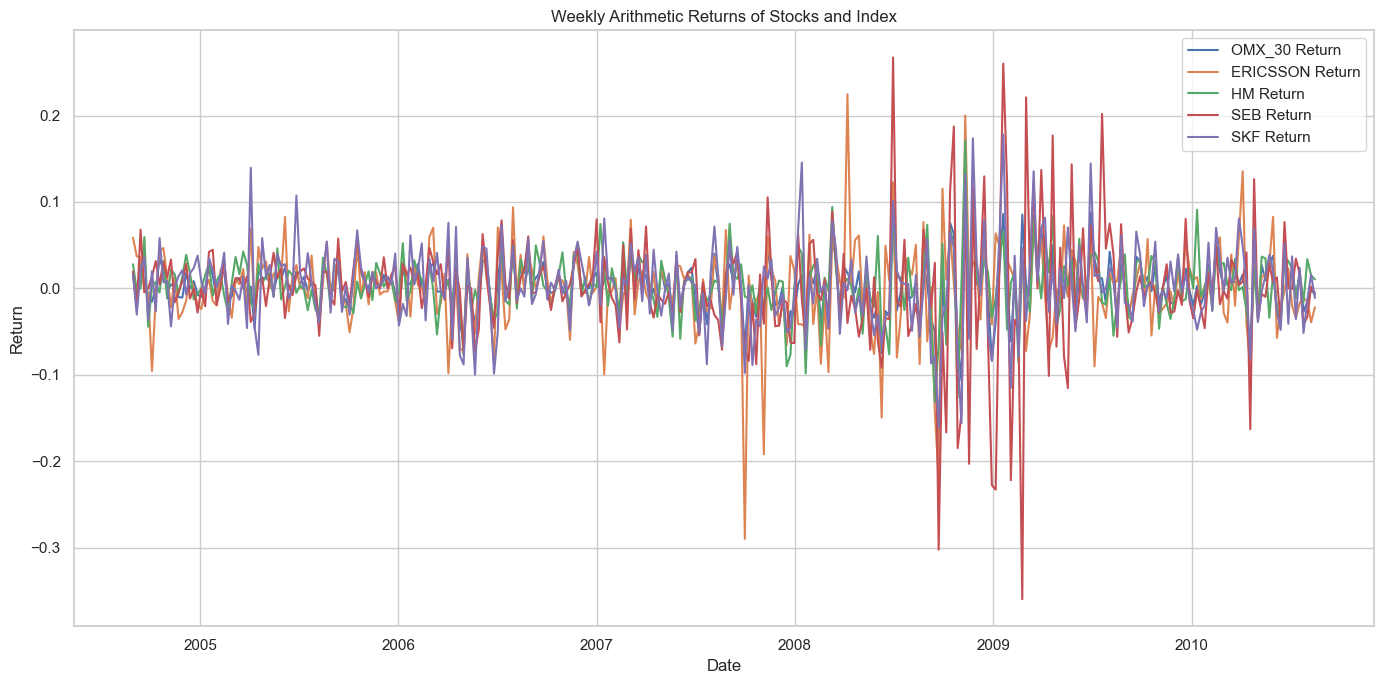

In [39]:

# arithmetic weekly returns
stock_columns = ['omx_30', 'ericsson', 'hm', 'seb', 'skf']
for col in stock_columns:
    df[f'{col}_ret'] = df[col].pct_change()

# plot returns
plt.figure(figsize=(14, 7))
for col in stock_columns:
    plt.plot(df.index, df[f'{col}_ret'], label=f'{col.upper()} Return')

plt.title('Weekly Arithmetic Returns of Stocks and Index')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 6

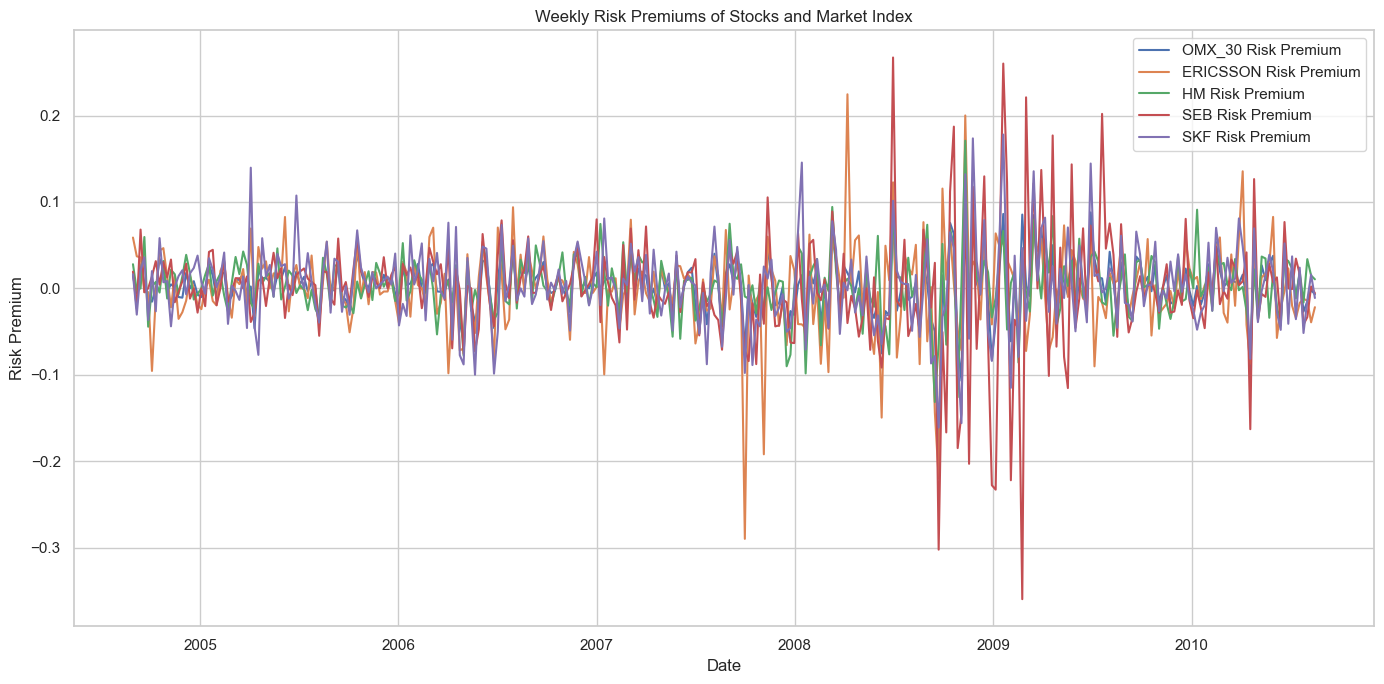

In [40]:
# calculate risk premiums: return - risk-free rate
for col in stock_columns:
    df[f'{col}_rp'] = df[f'{col}_ret'] - df['rf_weekly']

# plot risk premiums
plt.figure(figsize=(14, 7))
for col in stock_columns:
    plt.plot(df.index, df[f'{col}_rp'], label=f'{col.upper()} Risk Premium')

plt.title('Weekly Risk Premiums of Stocks and Market Index')
plt.xlabel('Date')
plt.ylabel('Risk Premium')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 7

In [41]:

# calculate logarithmic returns for Ericsson
df['ericsson_log_ret'] = np.log(df['ericsson'] / df['ericsson'].shift(1))
returns_compare = df[['ericsson_ret', 'ericsson_log_ret']].dropna()

# descriptive statistics
desc_stats = returns_compare.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# paired t-test
t_stat, p_val = stats.ttest_rel(returns_compare['ericsson_ret'], returns_compare['ericsson_log_ret'])

desc_stats['t_stat'] = t_stat
desc_stats['p_value'] = p_val

# output results
print("Q7: Ericsson Arithmetic vs Log Returns - Descriptive Statistics and t-test\n")
print(desc_stats.round(6))


Q7: Ericsson Arithmetic vs Log Returns - Descriptive Statistics and t-test

                      mean       std       min       25%  50%       75%  \
ericsson_ret      0.000378  0.049998 -0.289947 -0.021840  0.0  0.023841   
ericsson_log_ret -0.000912  0.051412 -0.342415 -0.022082  0.0  0.023561   

                       max    t_stat  p_value  
ericsson_ret      0.224591  5.567828      0.0  
ericsson_log_ret  0.202607  5.567828      0.0  


## Question 8

In [42]:

return_cols = ['omx_30_ret', 'ericsson_ret', 'hm_ret', 'seb_ret', 'skf_ret']
returns_df = df[return_cols].dropna()

# descriptive statistics
desc_stats_q8 = returns_df.describe().T[['mean', 'std', 'min', 'max']].round(6)

# Pearson correlation matrix
corr_matrix_q8 = returns_df.corr().round(3)

desc_stats_q8, corr_matrix_q8


(                  mean       std       min       max
 omx_30_ret    0.001748  0.032285 -0.201707  0.130600
 ericsson_ret  0.000378  0.049998 -0.289947  0.224591
 hm_ret        0.003973  0.035271 -0.131579  0.170891
 seb_ret       0.000183  0.066066 -0.359768  0.267193
 skf_ret       0.004138  0.047033 -0.161077  0.177987,
               omx_30_ret  ericsson_ret  hm_ret  seb_ret  skf_ret
 omx_30_ret         1.000         0.650   0.686    0.674    0.783
 ericsson_ret       0.650         1.000   0.397    0.274    0.435
 hm_ret             0.686         0.397   1.000    0.407    0.544
 seb_ret            0.674         0.274   0.407    1.000    0.537
 skf_ret            0.783         0.435   0.544    0.537    1.000)

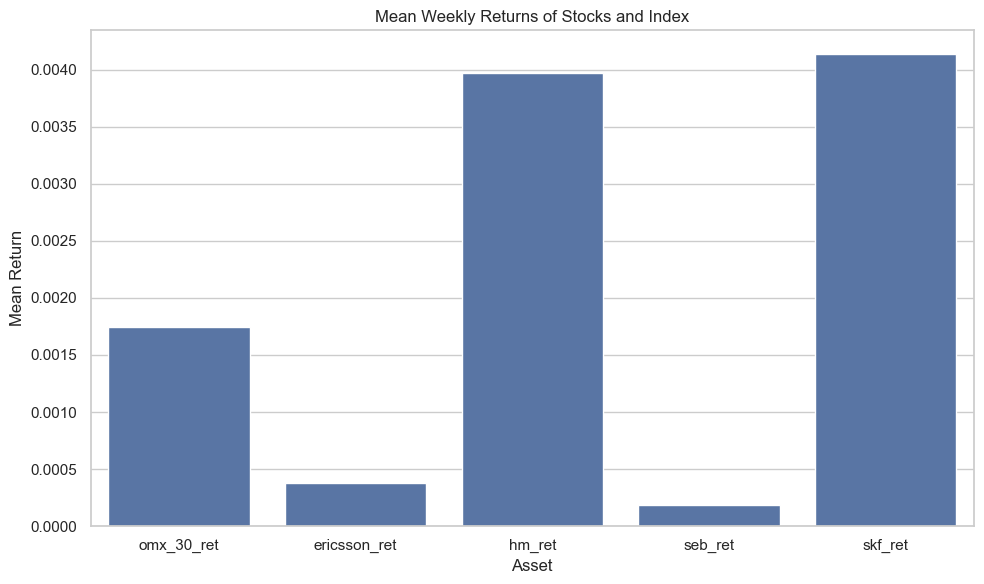

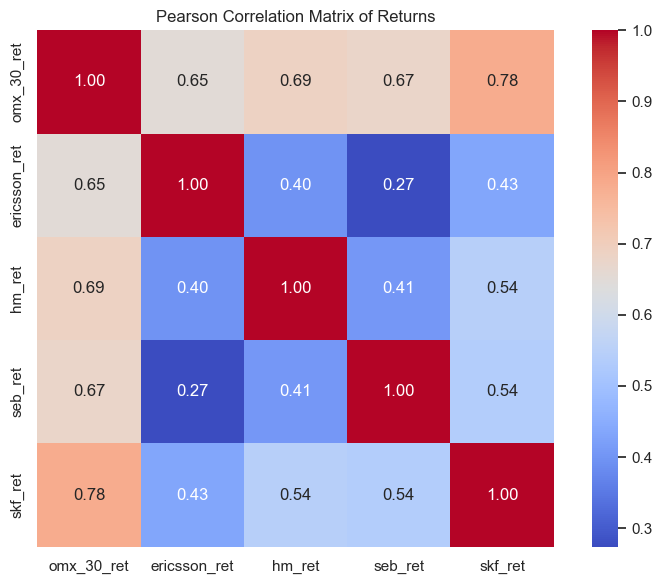

In [43]:

sns.set(style="whitegrid")

# Barplot for mean returns
plt.figure(figsize=(10, 6))
sns.barplot(x=returns_df.mean().index, y=returns_df.mean().values)
plt.title('Mean Weekly Returns of Stocks and Index')
plt.ylabel('Mean Return')
plt.xlabel('Asset')
plt.tight_layout()
plt.show()

# Heatmap of Pearson Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_q8, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Pearson Correlation Matrix of Returns")
plt.tight_layout()
plt.show()


## Question 9

In [44]:

# Calculate market risk premium
df['rm_rf'] = df['omx_30_ret'] - df['rf_weekly']

# Run CAPM regression for each stock
results = []
for stock in ['ericsson', 'hm', 'seb', 'skf']:
    df[f'{stock}_rp'] = df[f'{stock}_ret'] - df['rf_weekly']
    data = df[['rm_rf', f'{stock}_rp']].dropna()
    X = sm.add_constant(data['rm_rf'])
    y = data[f'{stock}_rp']
    model = sm.OLS(y, X).fit()
    
    results.append({
        'Stock': stock,
        'alpha': model.params['const'],
        'beta': model.params['rm_rf'],
        'R_squared': model.rsquared,
        'F_stat': model.fvalue,
        'alpha_tstat': model.tvalues['const'],
        'alpha_pval': model.pvalues['const'],
        'beta_tstat': model.tvalues['rm_rf'],
        'beta_pval': model.pvalues['rm_rf']
    })

# Convert to DataFrame
capm_df = pd.DataFrame(results).set_index('Stock').round(6)

# Show the results
print(capm_df)


             alpha      beta  R_squared      F_stat  alpha_tstat  alpha_pval  \
Stock                                                                          
ericsson -0.001380  1.006148   0.422095  226.420212    -0.639557    0.522933   
hm        0.002662  0.749340   0.470447  275.399800     1.826183    0.068784   
seb      -0.002226  1.379226   0.454278  258.054913    -0.803015    0.422582   
skf       0.002145  1.140491   0.612878  490.781807     1.290899    0.197700   

          beta_tstat  beta_pval  
Stock                            
ericsson   15.047266        0.0  
hm         16.595174        0.0  
seb        16.064088        0.0  
skf        22.153596        0.0  


## Question 10

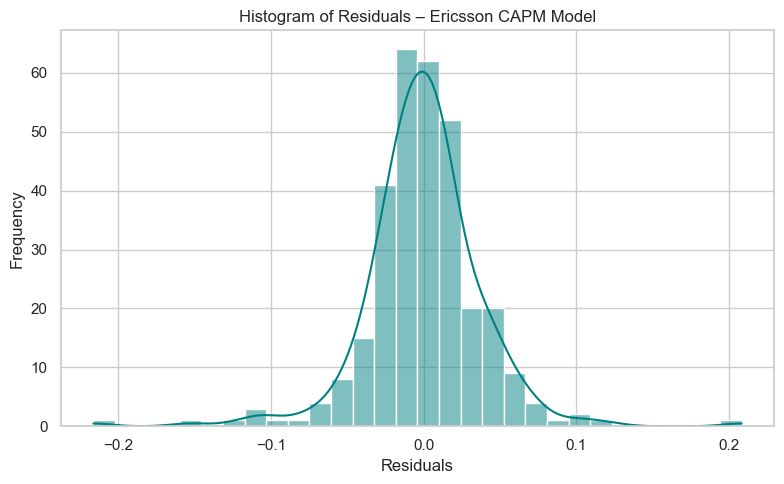

(np.float64(0.9137574115912168), np.float64(2.1396186608784406e-12))

In [45]:
# Residual analysis for Ericsson CAPM model

# Run regression for Ericsson again (for residual diagnostics)
df['ericsson_rp'] = df['ericsson_ret'] - df['rf_weekly']
capm_data = df[['ericsson_rp', 'rm_rf']].dropna()
X = sm.add_constant(capm_data['rm_rf'])
y = capm_data['ericsson_rp']
ericsson_model = sm.OLS(y, X).fit()
residuals = ericsson_model.resid

# Plot histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='teal')
plt.title('Histogram of Residuals – Ericsson CAPM Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Shapiro-Wilk test for normality
w_stat, p_value = shapiro(residuals)

w_stat, p_value


## Question 11

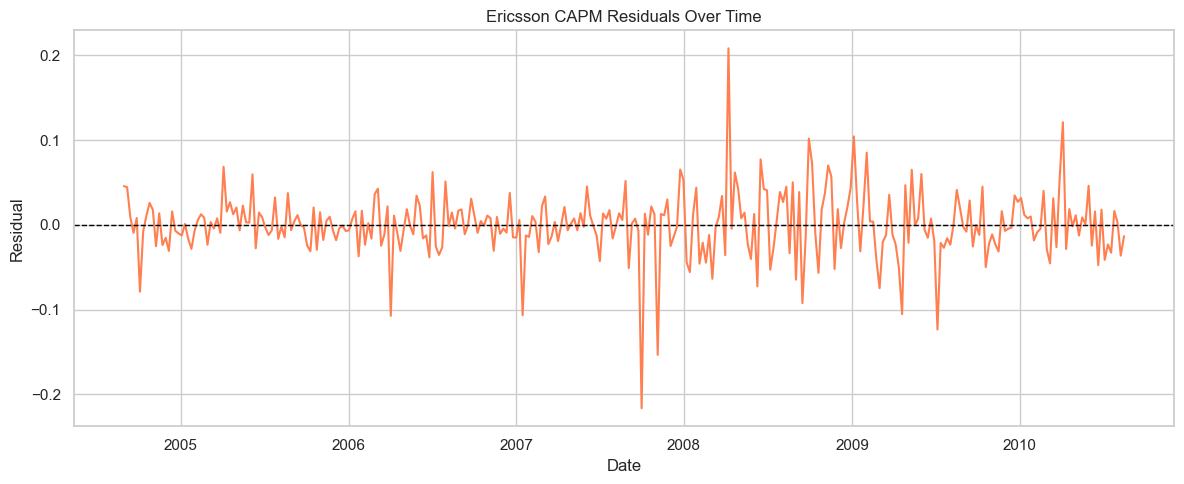

(np.float64(-0.01290839738367864), np.float64(0.8206299200776258))

In [46]:
# Residual autocorrelation – correlation between residuals and lagged residuals

# Create lagged residuals
df.loc[capm_data.index, 'resid'] = residuals
df['lag_resid'] = df['resid'].shift(1)

# Drop NA and compute correlation
autocorr_df = df[['resid', 'lag_resid']].dropna()
corr, corr_pval = pearsonr(autocorr_df['resid'], autocorr_df['lag_resid'])

# Plot residuals over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['resid'], label='Residuals', color='coral')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Ericsson CAPM Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

corr, corr_pval


## Question 12

In [47]:
# Breusch-Pagan test for heteroscedasticity of residuals

# Use residuals and independent variables from the Ericsson CAPM model
bp_test = het_breuschpagan(residuals, X)

# Organize results
bp_labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_results = dict(zip(bp_labels, bp_test))

bp_results


{'LM Statistic': np.float64(2.391631827228789),
 'LM p-value': np.float64(0.12198623375614165),
 'F Statistic': np.float64(2.3946570656875528),
 'F p-value': np.float64(0.1227706862171331)}

## Question 13

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Multicollinearity check – VIF calculation
# Add risk premiums of other stocks as regressors in the Ericsson model
df['hm_rp'] = df['hm_ret'] - df['rf_weekly']
df['seb_rp'] = df['seb_ret'] - df['rf_weekly']
df['skf_rp'] = df['skf_ret'] - df['rf_weekly']

# Prepare data for VIF (excluding NA)
vif_df = df[['rm_rf', 'hm_rp', 'seb_rp', 'skf_rp']].dropna()
X_vif = sm.add_constant(vif_df)

# Calculate VIFs
vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data.round(2)


,Variable,VIF
0,const,1.02
1,rm_rf,4.41
2,hm_rp,1.91
3,seb_rp,1.85
4,skf_rp,2.58


## Question 14

In [49]:
# CAPM model with interaction effect – D_crises and D_crises * Rm_rf

# Step 1: Create crisis dummy variable
df['D_crises'] = 0
df.loc[(df.index >= '2008-01-01') & (df.index <= '2008-12-31'), 'D_crises'] = pd.NA  # exclude crisis year
df.loc[df.index >= '2009-01-01', 'D_crises'] = 1

# Step 2: Create interaction term
df['D_crises_Rm_rf'] = df['D_crises'] * df['rm_rf']

# Step 3: Filter data and run regression
interaction_data = df[['ericsson_rp', 'rm_rf', 'D_crises', 'D_crises_Rm_rf']].dropna()
X_int = sm.add_constant(interaction_data[['rm_rf', 'D_crises', 'D_crises_Rm_rf']])
y_int = interaction_data['ericsson_rp']
interaction_model = sm.OLS(y_int, X_int).fit()

interaction_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ericsson_rp   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     56.92
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           3.17e-28
Time:                        04:27:21   Log-Likelihood:                 519.72
No. Observations:                 260   AIC:                            -1031.
Df Residuals:                     256   BIC:                            -1017.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0035      0.003     -1.403      0.162      -0.008       0.001
rm_rf              1.3456      0.114     11.813      0.000       1.121       1.570
D_crises           0.0033      0.004      0.753      0.452      -0.005       0.012
D_crises_Rm_rf    -0.7385      0.159     -4.657      0.000      -1.051      -0.426
==============================================================================
Omnibus:                       78.202   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              483.294
Skew:                          -1.034   Prob(JB):                    1.13e-105
Kurtosis:                       9.351   Cond. No.                         94.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""